<a href="https://colab.research.google.com/github/Beanzema/sdudying/blob/main/hw_5(3)_11st_Shopping_Review_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 91 (delta 43), reused 22 (delta 6), pack-reused 0
Unpacking objects: 100% (91/91), done.
/content/Mecab-ko-for-Google-Colab/Mecab-ko-for-Google-Colab
Installing konlpy.....
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2021-09-07 02:52:22--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22c2:513, 2406:da00:ff00::34cc:ea4a, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuseruploads.s3.amazonaws.com/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz?Signature=LQaVQ4bMYitMGBnUZcotwZv%2BsRU%3D&Expires=16309

# 11번가 리뷰 감성 분석하기

In [3]:
# 필요한 라이브러리를 가져온다.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
# 지난번 과제에서 추출된 11번가 리뷰 데이터를 활용한다. raw_data에 리뷰 데이터를 할당하고, 첫 다섯개 리뷰를 확인해보자.
raw_data = pd.read_csv('/content/hw_3_webcrawling_kbw.csv', encoding='cp949')
raw_data.head()

,category,item_id,page,score,sentiment,review
0,chair,1815000878,1,3,0,분명 제품 크기를 일일이 확인하고 줄자로 재보고 해서 어느정도 크기일거라 생각하고 ...
1,chair,1815000878,1,5,1,진짜 편해요 등받이도 크고 메쉬소재라 여름에도 땀차지않고 좋을것같아요 특히 좋은건 ...
2,chair,1815000878,1,1,-1,별한개도 아깝습니다 배송이안와서 전화하니 두번이나 내일연락준다고 하더니 일주일만에 ...
3,chair,1815000878,1,1,-1,박스 열고 앉는 아래부분 파손된거 확인하였으나 사용하는데 지장 없는곳이라 반품은 하...
4,chair,1815000878,1,1,-1,부품 불량 및 누락으로교체했으나 다시 불량품이 배송되어 불량 부품만 교환해 달라고 ...


In [5]:
# score가 3이면 sentiment가 0인 것 같다. 혹시 아닐 수 있으니 score가 3인 행들만 확인해보고, sentiment가 중복값이 없는지 확인해보자.
raw_data[raw_data['score']==3]['sentiment'].nunique()

1

In [6]:
# 우리가 필요로 하는 것은 sentiment가 1, -1인 행들, 그 중에서도 sentiment 열과 review 열만 필요하다. 추출하자.
preprocessed_data = raw_data[raw_data['score'] != 3][['sentiment', 'review']]
preprocessed_data.head()

,sentiment,review
1,1,진짜 편해요 등받이도 크고 메쉬소재라 여름에도 땀차지않고 좋을것같아요 특히 좋은건 ...
2,-1,별한개도 아깝습니다 배송이안와서 전화하니 두번이나 내일연락준다고 하더니 일주일만에 ...
3,-1,박스 열고 앉는 아래부분 파손된거 확인하였으나 사용하는데 지장 없는곳이라 반품은 하...
4,-1,부품 불량 및 누락으로교체했으나 다시 불량품이 배송되어 불량 부품만 교환해 달라고 ...
5,-1,상품 디자인은 예쁘고 맘에 드는데 사진상 보이는 부분이 깨져서 왔습니다 .저말고도 ...


In [7]:
# review의 중복행을 제거하자.
# preprocessed_data['review'].nunique(), len(preprocessed_data)    ---->    (62495, 99849)
preprocessed_data.drop_duplicates(subset=['review'], inplace=True)

In [8]:
# preprocessed_data['review'].nunique(), len(preprocessed_data)    ---->    (62495, 62495)
# 이제는 Null 값을 제거하자.
# preprocessed_data['review'].isnull().values.any()    ---->    False 없다.

In [9]:
# len(preprocessed_data) == 62495
# 꽤나 많은 데이터이므로, 6:4로 나눠보자.
train_data, test_data = train_test_split(preprocessed_data, test_size = 0.4, random_state = 7)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 37497
테스트용 리뷰의 개수 : 24998


   sentiment  count
0         -1   1788
1          1  35709


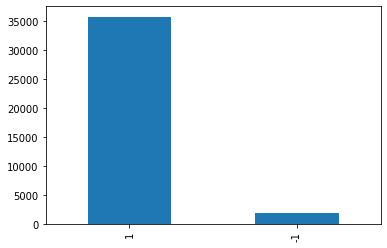

In [10]:
print(train_data.groupby('sentiment').size().reset_index(name='count'))
train_data['sentiment'].value_counts().plot(kind = 'bar');

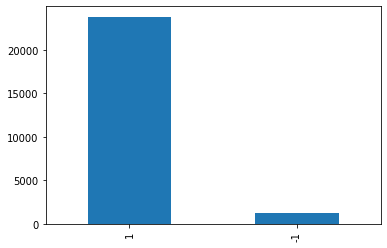

In [12]:
# 빈도를 보니 뭔가 잘못될 수도 있을 것 같다. 부정리뷰가 1800개도 안된다. 우선은 머신러닝을 수행해보고, epoch를 낮춰 과접합을 막자.
# 혹시나 한 test 데이터 역시 확인해보더라도 같은 분포다.
test_data['sentiment'].value_counts().plot(kind = 'bar');

## 데이터 정제

In [15]:
# review 열의 한글과 공백을 제외하고 모두 제거
train_data['review'] = train_data['review'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '')
print(train_data.isnull().sum())
test_data['review'] = test_data['review'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]','')
print(test_data.isnull().sum())

sentiment    0
review       0
dtype: int64
sentiment    0
review       0
dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [16]:
# Null 값 없다. 계속 진행하자.
# Mecab을 다운받았으니 Mecab을 쓰겠지만, 이후 Okt도 한번 해보자.
mecab = Mecab()

stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

train_data['tokenized'] = train_data['review'].apply(mecab.morphs)
train_data['tokenized'] = train_data['review'].apply(lambda x: [item for item in x if item not in stopwords])

test_data['tokenized'] = test_data['review'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

## 정수 인코딩

In [21]:
# 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩.

# 아래 알고리즘은 네이버 쇼핑 감성분석 중 빈도수 측정 알고리즘 

X_train = train_data['tokenized'].values
y_train = train_data['sentiment'].values
X_test = test_data['tokenized'].values
y_test = test_data['sentiment'].values

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

threshold = 2
total_cnt = len(tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for keys, value in tokenizer.word_counts.items():
  total_freq += value

  if (value < threshold):
    rare_cnt += 1
    rare_freq += value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s' %(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어의 비율 :', (rare_cnt / total_cnt)*100)
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율 :', (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 1671
등장 빈도가 1번 이하인 희귀 단어의 수: 208
단어 집합에서 희귀 단어의 비율 : 12.447636146020347
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : 0.014913483868701116


In [22]:
# 아주 등장 빈도가 낮다. 빈도 1인 단어들 없애고 감성분석 하자.
vocab_size = total_cnt - rare_cnt + 2
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# 정수 인코딩이 어떻게 되었는지 상위 3개 샘플씩 확인해보자.
print(X_train[:3])
print(X_test[:3])

[[36, 187, 617, 167, 24, 16, 7, 2, 96, 5, 2, 93, 152, 5, 2, 45, 27, 2, 75, 67, 2, 185, 5, 2, 2, 107, 186, 2, 70, 68, 4, 3], [101, 55, 2, 6, 4, 3, 2, 188, 11, 2, 131, 133, 111, 95, 2, 292, 2, 77, 2, 389, 8, 3], [253, 31, 2, 25, 2, 13, 64, 2, 45, 27, 2, 6, 4, 2, 219, 2, 13, 64, 32, 3, 2, 52, 10, 286, 36, 2, 561, 36, 2, 91, 2, 8, 2, 21, 2, 6, 3, 2, 96, 100, 96, 100, 2, 576, 46, 51, 2, 6, 98, 3]]
[[1, 1, 1, 1, 1, 1, 6, 1], [1, 1], [1, 1, 1, 1, 6, 1, 6, 1, 1, 1, 1, 1, 201, 1, 1, 22, 1, 98, 1, 1, 1, 57, 1, 1, 1]]


## 패딩

리뷰의 최대 길이 : 1475
리뷰의 평균 길이 : 37.19526895484972


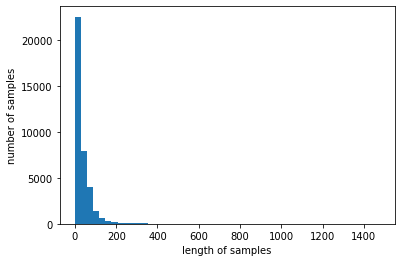

In [23]:
# 서로 다른 길이 샘플들을 같은 길이로 맞춰주는 작업.
# 전체 데이터의 샘플들의 길이 분포를 알아보자.

print('리뷰의 최대 길이 :', max(len(l) for l in X_train))
print('리뷰의 평균 길이 :', sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [28]:
# 최대 길이가 1475이다. 만약 390으로 패딩할 경우 얼마나 샘플들을 보전할 수 있는지 보자.
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if (len(s) <= max_len):
      cnt += 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율 : %s'%(max_len, (cnt/len(nested_list)*100)))

max_len = 390
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 390 이하인 샘플의 비율 : 99.7839827186175


In [29]:
# not bad하다. training 리뷰의 길이를 390으로 패딩하자.
X_train = pad_sequences(X_train, maxlen= max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

## 11번가 쇼핑 리뷰 by GRU

In [35]:
from tensorflow.keras.layers import Embedding, Dense, GRU, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [31]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(GRU(128))
model.add(Dense(1, activation='sigmoid'))

In [32]:
es = EarlyStopping(monitor='val_loss', mode = 'min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [33]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs = 15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
500/500 [==============================] - 45s 77ms/step - loss: 0.2183 - acc: 0.9237 - val_loss: 0.1477 - val_acc: 0.9301

Epoch 00001: val_acc improved from -inf to 0.93013, saving model to best_model.h5
Epoch 2/15
500/500 [==============================] - 37s 74ms/step - loss: 0.0889 - acc: 0.9182 - val_loss: 0.0427 - val_acc: 0.9104

Epoch 00002: val_acc did not improve from 0.93013
Epoch 3/15
500/500 [==============================] - 37s 74ms/step - loss: -0.0502 - acc: 0.9246 - val_loss: 0.8415 - val_acc: 0.8380

Epoch 00003: val_acc did not improve from 0.93013
Epoch 4/15
500/500 [==============================] - 37s 74ms/step - loss: -0.2502 - acc: 0.9197 - val_loss: -0.3473 - val_acc: 0.9253

Epoch 00004: val_acc did not improve from 0.93013
Epoch 5/15
500/500 [==============================] - 35s 69ms/step - loss: -0.4821 - acc: 0.9171 - val_loss: -0.4172 - val_acc: 0.9323

Epoch 00005: val_acc improved from 0.93013 to 0.93227, saving model to best_model.h5
Epo

In [34]:
loaded_model = load_model('best_model.h5')
print('\n 테스트 정확도 : %.4f' %(loaded_model.evaluate(X_test, y_test)[1]))

782/782 [==============================] - 23s 29ms/step - loss: 0.8825 - acc: 0.9509

 테스트 정확도 : 0.9509


In [36]:
# 성능이 안좋을거라 예상했는데 아주 좋아서 무안하다. LSTM으로도 진행해보자.

model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', model='max', verbose=1, save_best_only=True)

In [37]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split = 0.2)

Epoch 1/15
500/500 [==============================] - 41s 76ms/step - loss: 0.1874 - acc: 0.9280 - val_loss: 0.1135 - val_acc: 0.9319

Epoch 00001: val_acc improved from -inf to 0.93187, saving model to best_model.h5
Epoch 2/15
500/500 [==============================] - 37s 74ms/step - loss: 0.0599 - acc: 0.9242 - val_loss: -0.0433 - val_acc: 0.9117

Epoch 00002: val_acc did not improve from 0.93187
Epoch 3/15
500/500 [==============================] - 37s 75ms/step - loss: -0.1037 - acc: 0.9241 - val_loss: -0.2193 - val_acc: 0.9175

Epoch 00003: val_acc did not improve from 0.93187
Epoch 4/15
500/500 [==============================] - 37s 75ms/step - loss: -0.3109 - acc: 0.9223 - val_loss: 0.0087 - val_acc: 0.8960

Epoch 00004: val_acc did not improve from 0.93187
Epoch 5/15
500/500 [==============================] - 40s 80ms/step - loss: -0.6189 - acc: 0.9230 - val_loss: -0.5543 - val_acc: 0.9197

Epoch 00005: val_acc did not improve from 0.93187
Epoch 6/15
500/500 [=================

In [38]:
loaded_model = load_model('best_model.h5')
print('\n 테스트 정확도 : %.4f' %(loaded_model.evaluate(X_test, y_test)[1]))

782/782 [==============================] - 23s 29ms/step - loss: 0.7122 - acc: 0.9508

 테스트 정확도 : 0.9508


* 둘 다 95.07 ~ 95.08%로 높은 accuracy을 보여주었으나, LSTM이 좀 더 낮은 loss율을 보여주었다.